In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
from torchvision.models import resnet18
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from tqdm import tqdm

In [2]:
glaucoma_img_dir = "/kaggle/input/dataset499/suspicious_glaucoma/image"
normal_img_dir = "/kaggle/input/dataset499/non_glaucoma/image"
glaucoma_label_dir = "/kaggle/input/dataset499/suspicious_glaucoma/label"
normal_label_dir = "/kaggle/input/dataset499/non_glaucoma/label"

In [3]:
def load_image_paths_labels(image_dir, label_dir):
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.txt')])
    labels = [int(open(p).read().strip()) for p in label_paths]
    return image_paths, labels

glaucoma_imgs, glaucoma_labels = load_image_paths_labels(glaucoma_img_dir, glaucoma_label_dir)
normal_imgs, normal_labels = load_image_paths_labels(normal_img_dir, normal_label_dir)
print(f"Glaucoma samples: {len(glaucoma_imgs)}, Normal samples: {len(normal_imgs)}")

Glaucoma samples: 1711, Normal samples: 3143


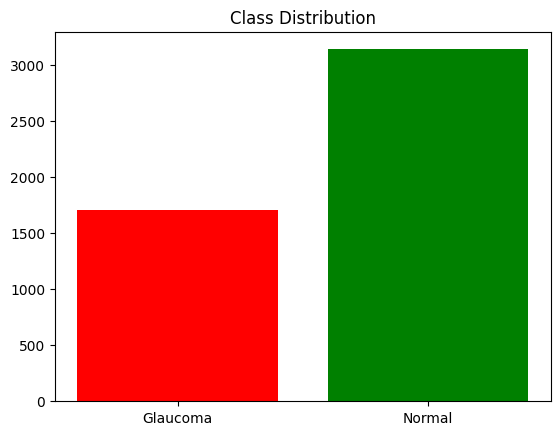

In [4]:
plt.bar(['Glaucoma', 'Normal'], [len(glaucoma_imgs), len(normal_imgs)], color=['red', 'green'])
plt.title('Class Distribution')
plt.show()

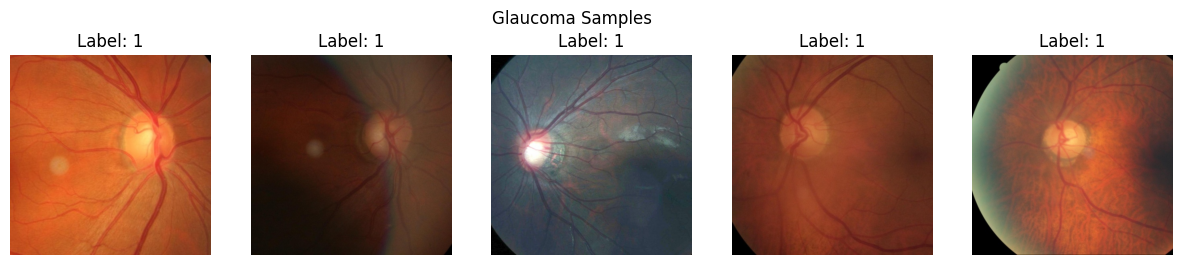

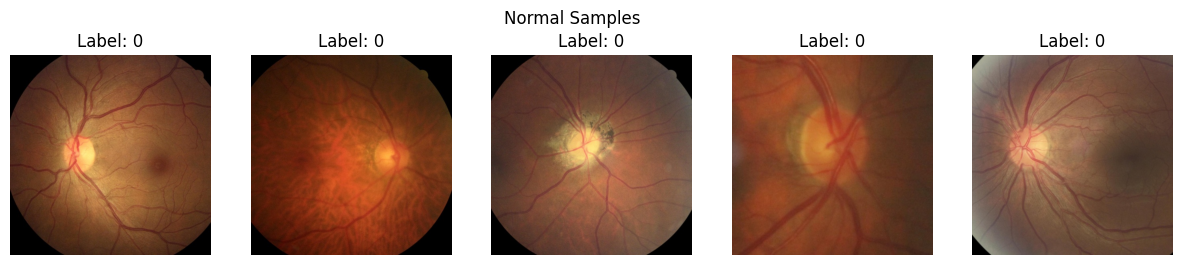

In [5]:
def show_samples(images, labels, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        img = Image.open(images[i])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Label: {labels[i]}')
    plt.suptitle(title)
    plt.show()

show_samples(glaucoma_imgs, glaucoma_labels, 'Glaucoma Samples')
show_samples(normal_imgs, normal_labels, 'Normal Samples')

In [6]:
class GlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [7]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [8]:
all_imgs = glaucoma_imgs + normal_imgs
all_labels = glaucoma_labels + normal_labels

In [9]:
train_imgs, val_imgs, train_labels, val_labels = train_test_split(all_imgs, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

In [10]:
train_dataset = GlaucomaDataset(train_imgs, train_labels, transform_train)
val_dataset = GlaucomaDataset(val_imgs, val_labels, transform_val)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [12]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to("cuda")
print("Class Weights:", class_weights)

Class Weights: tensor([0.7722, 1.4185], device='cuda:0')


In [13]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        return self.net(x)

In [14]:
def get_resnet():
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model

In [15]:
def train_model(model, train_loader, val_loader, epochs=50):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # Weighted binary loss
    criterion = nn.BCEWithLogitsLoss(weight=class_weights[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    patience = 5
    wait = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print("-" * 40)

        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_bar = tqdm(train_loader, desc="Training", leave=False)
        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Accuracy
            preds = torch.sigmoid(outputs) > 0.5
            train_correct += (preds == labels.bool()).sum().item()
            train_total += labels.size(0)

            train_bar.set_postfix(loss=loss.item())

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        val_bar = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Accuracy
                preds = torch.sigmoid(outputs) > 0.5
                val_correct += (preds == labels.bool()).sum().item()
                val_total += labels.size(0)

                val_bar.set_postfix(loss=loss.item())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # ReduceLROnPlateau
        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            wait = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved new best model!")
        else:
            wait += 1
            print(f"⏳ No improvement... (wait {wait}/{patience})")
            if wait >= patience:
                print("Early stopping triggered!")
                break

    model.load_state_dict(best_model_wts)
    return model

In [16]:
# Train Custom CNN
custom_model = CustomCNN()
trained_custom = train_model(custom_model, train_loader, val_loader)

# Train ResNet18
resnet_model = get_resnet()
trained_resnet = train_model(resnet_model, train_loader, val_loader)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/50
----------------------------------------


Train Loss: 0.7329 | Val Loss: 0.6512 | Train Acc: 0.7417 | Val Acc: 0.7497 | LR: 0.000100
Saved new best model!

Epoch 2/50
----------------------------------------


Train Loss: 0.5730 | Val Loss: 0.5177 | Train Acc: 0.8153 | Val Acc: 0.8465 | LR: 0.000100
Saved new best model!

Epoch 3/50
----------------------------------------


Train Loss: 0.5189 | Val Loss: 0.4338 | Train Acc: 0.8416 | Val Acc: 0.8702 | LR: 0.000100
Saved new best model!

Epoch 4/50
----------------------------------------


Train Loss: 0.4789 | Val Loss: 0.4033 | Train Acc: 0.8584 | Val Acc: 0.8929 | LR: 0.000100
Saved new best model!

Epoch 5/50
----------------------------------------


Train Loss: 0.4513 | Val Loss: 0.3894 | Train Acc: 0.8687 | Val Acc: 0.8723 | LR: 0.000100
Saved new best model!

Epoch 6/50
----------------------------------------


Train Loss: 0.4048 | Val Loss: 0.3428 | Train Acc: 0.8764 | Val Acc: 0.9022 | LR: 0.000100
Saved new best model!

Epoch 7/50
----------------------------------------


Train Loss: 0.4034 | Val Loss: 0.3569 | Train Acc: 0.8810 | Val Acc: 0.8939 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 8/50
----------------------------------------


Train Loss: 0.3936 | Val Loss: 0.3469 | Train Acc: 0.8836 | Val Acc: 0.8970 | LR: 0.000100
⏳ No improvement... (wait 2/5)

Epoch 9/50
----------------------------------------


Train Loss: 0.3695 | Val Loss: 0.3211 | Train Acc: 0.8859 | Val Acc: 0.9032 | LR: 0.000100
Saved new best model!

Epoch 10/50
----------------------------------------


Train Loss: 0.3578 | Val Loss: 0.2913 | Train Acc: 0.8983 | Val Acc: 0.9125 | LR: 0.000100
Saved new best model!

Epoch 11/50
----------------------------------------


Train Loss: 0.3425 | Val Loss: 0.3142 | Train Acc: 0.8970 | Val Acc: 0.9156 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 12/50
----------------------------------------


Train Loss: 0.3274 | Val Loss: 0.2753 | Train Acc: 0.9016 | Val Acc: 0.9217 | LR: 0.000100
Saved new best model!

Epoch 13/50
----------------------------------------


Train Loss: 0.3195 | Val Loss: 0.2907 | Train Acc: 0.9024 | Val Acc: 0.9145 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 14/50
----------------------------------------


Train Loss: 0.3315 | Val Loss: 0.2902 | Train Acc: 0.9050 | Val Acc: 0.9217 | LR: 0.000100
⏳ No improvement... (wait 2/5)

Epoch 15/50
----------------------------------------


Train Loss: 0.2911 | Val Loss: 0.2819 | Train Acc: 0.9163 | Val Acc: 0.9217 | LR: 0.000100
⏳ No improvement... (wait 3/5)

Epoch 16/50
----------------------------------------


Train Loss: 0.3087 | Val Loss: 0.2855 | Train Acc: 0.9135 | Val Acc: 0.9197 | LR: 0.000030
⏳ No improvement... (wait 4/5)

Epoch 17/50
----------------------------------------


Train Loss: 0.2784 | Val Loss: 0.2512 | Train Acc: 0.9230 | Val Acc: 0.9300 | LR: 0.000030
Saved new best model!

Epoch 18/50
----------------------------------------


Train Loss: 0.2642 | Val Loss: 0.2505 | Train Acc: 0.9212 | Val Acc: 0.9269 | LR: 0.000030
Saved new best model!

Epoch 19/50
----------------------------------------


Train Loss: 0.2525 | Val Loss: 0.2858 | Train Acc: 0.9318 | Val Acc: 0.9176 | LR: 0.000030
⏳ No improvement... (wait 1/5)

Epoch 20/50
----------------------------------------


Train Loss: 0.2556 | Val Loss: 0.2512 | Train Acc: 0.9276 | Val Acc: 0.9258 | LR: 0.000030
⏳ No improvement... (wait 2/5)

Epoch 21/50
----------------------------------------


Train Loss: 0.2447 | Val Loss: 0.2615 | Train Acc: 0.9310 | Val Acc: 0.9289 | LR: 0.000030
⏳ No improvement... (wait 3/5)

Epoch 22/50
----------------------------------------


Train Loss: 0.2524 | Val Loss: 0.2396 | Train Acc: 0.9261 | Val Acc: 0.9279 | LR: 0.000030
Saved new best model!

Epoch 23/50
----------------------------------------


Train Loss: 0.2370 | Val Loss: 0.2530 | Train Acc: 0.9300 | Val Acc: 0.9269 | LR: 0.000030
⏳ No improvement... (wait 1/5)

Epoch 24/50
----------------------------------------


Train Loss: 0.2347 | Val Loss: 0.2441 | Train Acc: 0.9333 | Val Acc: 0.9331 | LR: 0.000030
⏳ No improvement... (wait 2/5)

Epoch 25/50
----------------------------------------


Train Loss: 0.2305 | Val Loss: 0.2428 | Train Acc: 0.9346 | Val Acc: 0.9289 | LR: 0.000030
⏳ No improvement... (wait 3/5)

Epoch 26/50
----------------------------------------


Train Loss: 0.2282 | Val Loss: 0.2437 | Train Acc: 0.9382 | Val Acc: 0.9341 | LR: 0.000009
⏳ No improvement... (wait 4/5)

Epoch 27/50
----------------------------------------


Train Loss: 0.2178 | Val Loss: 0.2359 | Train Acc: 0.9369 | Val Acc: 0.9382 | LR: 0.000009
Saved new best model!

Epoch 28/50
----------------------------------------


Train Loss: 0.2220 | Val Loss: 0.2374 | Train Acc: 0.9397 | Val Acc: 0.9372 | LR: 0.000009
⏳ No improvement... (wait 1/5)

Epoch 29/50
----------------------------------------


Train Loss: 0.2130 | Val Loss: 0.2369 | Train Acc: 0.9408 | Val Acc: 0.9382 | LR: 0.000009
⏳ No improvement... (wait 2/5)

Epoch 30/50
----------------------------------------


Train Loss: 0.2126 | Val Loss: 0.2386 | Train Acc: 0.9421 | Val Acc: 0.9403 | LR: 0.000009
⏳ No improvement... (wait 3/5)

Epoch 31/50
----------------------------------------


Train Loss: 0.2157 | Val Loss: 0.2405 | Train Acc: 0.9395 | Val Acc: 0.9392 | LR: 0.000003
⏳ No improvement... (wait 4/5)

Epoch 32/50
----------------------------------------


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Train Loss: 0.2067 | Val Loss: 0.2373 | Train Acc: 0.9436 | Val Acc: 0.9382 | LR: 0.000003
⏳ No improvement... (wait 5/5)
Early stopping triggered!


100%|██████████| 44.7M/44.7M [00:00<00:00, 81.2MB/s]



Epoch 1/50
----------------------------------------


Train Loss: 0.3547 | Val Loss: 0.2490 | Train Acc: 0.8900 | Val Acc: 0.9372 | LR: 0.000100
Saved new best model!

Epoch 2/50
----------------------------------------


Train Loss: 0.1771 | Val Loss: 0.1770 | Train Acc: 0.9506 | Val Acc: 0.9516 | LR: 0.000100
Saved new best model!

Epoch 3/50
----------------------------------------


Train Loss: 0.1493 | Val Loss: 0.1251 | Train Acc: 0.9645 | Val Acc: 0.9691 | LR: 0.000100
Saved new best model!

Epoch 4/50
----------------------------------------


Train Loss: 0.1253 | Val Loss: 0.1260 | Train Acc: 0.9694 | Val Acc: 0.9650 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 5/50
----------------------------------------


Train Loss: 0.0825 | Val Loss: 0.1411 | Train Acc: 0.9807 | Val Acc: 0.9691 | LR: 0.000100
⏳ No improvement... (wait 2/5)

Epoch 6/50
----------------------------------------


Train Loss: 0.0672 | Val Loss: 0.1518 | Train Acc: 0.9853 | Val Acc: 0.9701 | LR: 0.000100
⏳ No improvement... (wait 3/5)

Epoch 7/50
----------------------------------------


Train Loss: 0.0671 | Val Loss: 0.2171 | Train Acc: 0.9827 | Val Acc: 0.9506 | LR: 0.000030
⏳ No improvement... (wait 4/5)

Epoch 8/50
----------------------------------------


Train Loss: 0.0354 | Val Loss: 0.1275 | Train Acc: 0.9915 | Val Acc: 0.9753 | LR: 0.000030
⏳ No improvement... (wait 5/5)
Early stopping triggered!
